In [1]:
import torch
from torch import nn
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from LSTM import *
import pandas as pd
import numpy as np
import torch.utils.data as utils
import time
import os
import pickle

import pdb

# For the notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2

torch.manual_seed(1)

In [2]:
gt_test_coord_1 = pickle.load( open( "../import_dataset_3/test/gt_test_coord_1.pkl", "rb" ) )
in_test_coord_1 = pickle.load( open( "../import_dataset_3/test/in_test_coord_1.pkl", "rb" ) )
inputs_test_1 = pickle.load( open( "../import_dataset_3/test/inputs_test_1.pkl", "rb" ) )

gt_test_coord_2 = pickle.load( open( "../import_dataset_3/test/gt_test_coord_2.pkl", "rb" ) )
in_test_coord_2 = pickle.load( open( "../import_dataset_3/test/in_test_coord_2.pkl", "rb" ) )
inputs_test_2 = pickle.load( open( "../import_dataset_3/test/inputs_test_2.pkl", "rb" ) )

gt_test_coord_3 = pickle.load( open( "../import_dataset_3/test/gt_test_coord_3.pkl", "rb" ) )
in_test_coord_3 = pickle.load( open( "../import_dataset_3/test/in_test_coord_3.pkl", "rb" ) )
inputs_test_3 = pickle.load( open( "../import_dataset_3/test/inputs_test_3.pkl", "rb" ) )

inputs_linear = np.concatenate((inputs_test_1,
                              inputs_test_2,inputs_test_3),axis=1)


inputs_speed = np.concatenate((inputs_test_1,inputs_test_2,inputs_test_3),axis=1)
in_coord = np.concatenate((in_test_coord_1,in_test_coord_2,in_test_coord_3),axis=1)
gt_coord = np.concatenate((gt_test_coord_1,gt_test_coord_2,gt_test_coord_3),axis=1)
inputs_speed = torch.from_numpy(inputs_speed).float()


## BEST LSTM

In [3]:
full_lstm = LSTM(input_size = inputs_test_1.shape[2], output_size = 4,
                 num_layers=2, hidden_size=128)
full_lstm.load_state_dict(torch.load('../model_rodolphe/model_results/2Loss_ND_3.pt'))

output_tmp = full_lstm.predict(inputs_speed)
output_tmp = output_tmp.data.numpy()

output_speed=np.zeros([11,inputs_speed.shape[1],2])
for j in range(11):
    for i in range(inputs_speed.shape[1]):
        if j==0:
            output_speed[j,i,:] = in_coord[9,i,:]
        else:
            output_speed[j,i,:] = output_speed[j-1,i,:2]+output_tmp[j-1,i,2:]*0.4

## BEST CNN

## LINEAR

In [4]:
def linearpred(inputs):
    output_coord = np.zeros((inputs.shape[0]+1,
                             inputs.shape[1],inputs.shape[2]))
    output_coord[0,:,:]=inputs[9,:,:]
    for i in range(inputs.shape[1]):
        if (inputs[9,i,0]-inputs[8,i,0])==0:
            output_coord[1:,i,0] =inputs[9,i,0]*np.ones(10)
            diff = inputs[9,i,1]-inputs[8,i,1]
            output_coord[1:,i,0] = range(10)*diff+inputs[9,i,1]
        else:
            slope = (inputs[9,i,1]-inputs[8,i,1])/(inputs[9,i,0]-inputs[8,i,0])
            ordor = inputs[9,i,1] - slope*inputs[9,i,0]
            diff = inputs[9,i,0] - inputs[8,i,0]
            output_coord[1:,i,0] = range(10)*diff+inputs[9,i,0]
            output_coord[1:,i,1] = slope*output_coord[1:,i,0]+ordor
    return output_coord

output_linear = linearpred(inputs_linear)

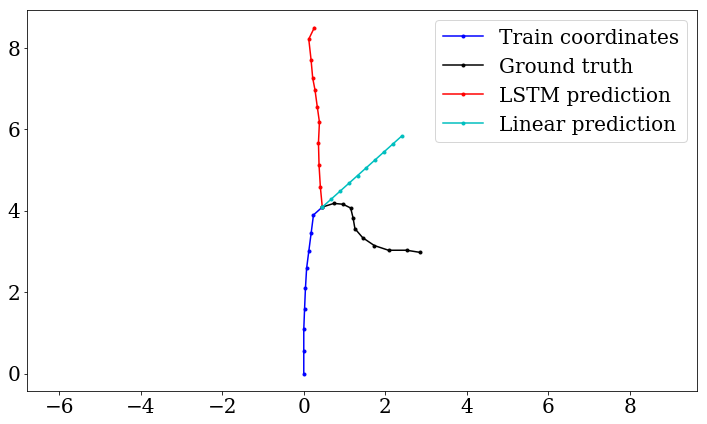

In [5]:
plt.figure(figsize=(12, 7))
plt.rc('font', family='serif')
plt.rc('font', size=20)

ind = 1621#510#1552#1634#510

plt.plot(in_coord[:,ind,0],in_coord[:,ind,1],c='b',marker='.',label='Train coordinates')
plt.plot(gt_coord[:,ind,0],gt_coord[:,ind,1],c='k',marker='.',label='Ground truth')
plt.plot(output_speed[:,ind,0],output_speed[:,ind,1],c='r',marker='.',label='LSTM prediction')
plt.plot(output_linear[:,ind,0],output_linear[:,ind,1],c='c',marker='.',label='Linear prediction')
plt.axis('equal')
#plt.xticks([-2,-1,0,1,2])
#plt.yticks([0,1,2,3,4])
plt.legend()
plt.savefig(r'../presentation/figure/fig_{}.pdf'.format(ind), bbox_inches='tight')

In [6]:
inputs_dyn = pickle.load( open( "../import_dataset_3/inputs_dyn_plot.pkl", "rb" ) )
inputs_dyn.shape

(20, 1718, 136)

In [11]:
def makeDynamicPlot(index_traj):
    """
    :param i: i is an index from 0 to number_traj and goes into unique_id to find the id
    :return: display a dynamic plot with trajectory i and the interacting traj
    """

    # Previous interaction
    traj = inputs_dyn[:,index_traj,:]
    ## Initialization of the plot#
    fig = plt.figure(figsize=(12, 7))

    ax1 = plt.axes(xlim=(-6, 8), ylim=(-0.5, 9))
    line, = ax1.plot([], [], marker='+')
    
    id_tmp = np.int(traj.shape[1]/2-1)
    surround={}
    index_s=0
    for w in range(id_tmp):
        if sum(sum((traj[:,(w+1)*2:(w+2)*2])!=0))>4:
            surround[index_s] = traj[:,(w+1)*2:(w+2)*2]
            index_s+=1

    # Creation of a dictionary with all interacting trajectories
    x_int, y_int = [], []
    x_gt, y_gt = [], []
    x_speed, y_speed = [], []
    x_lin, y_lin = [], []
    dictio = {}
    for j in range(len(surround)):
        dictio['x%s' % j] = []
        dictio['y%s' % j] = []
        dictio['tmp%s' % j] = surround[j]
        

    ## Plot initialization #2
    mar = ['o','o','o','o']
    col = ['b','k','r','c']
    alph = [1, 1, 1,1]
    lines = []
    for index in range(4+ len(surround)):
        if index < 4:
            lobj = ax1.plot([], [], marker=mar[index], color=col[index], alpha=alph[index])[0]
        else:
            lobj = ax1.plot([], [],linestyle='--',c='k',alpha=0.6,marker='.')[0]
        lines.append(lobj)

    # Initialization
    def init():
        for line in lines:
            line.set_data([], [])
        return lines

    # Create the animation
    def animate(i):
        label = 'timestep {0}'.format(i)
        if i < 10:
            xbis = traj[i,0]
            ybis = traj[i,1]
            x_int.append(xbis)
            y_int.append(ybis)
            if i==9:
                xbis = traj[i,0]
                ybis = traj[i,1]
                x_gt.append(xbis)
                y_gt.append(ybis)
                xbis2 = output_speed[i-9,index_traj,0]
                ybis2 = output_speed[i-9,index_traj,1]
                x_speed.append(xbis2)
                y_speed.append(ybis2)
                xbis3 = output_linear[i-9,index_traj,0]
                ybis3 = output_linear[i-9,index_traj,1]
                x_lin.append(xbis3)
                y_lin.append(ybis3)
        else:
            xbis = traj[i,0]
            ybis = traj[i,1]
            x_gt.append(xbis)
            y_gt.append(ybis)
            xbis2 = output_speed[i-9,index_traj,0]
            ybis2 = output_speed[i-9,index_traj,1]
            x_speed.append(xbis2)
            y_speed.append(ybis2)
            xbis3 = output_linear[i-9,index_traj,0]
            ybis3 = output_linear[i-9,index_traj,1]
            x_lin.append(xbis3)
            y_lin.append(ybis3)
        for j in range(len(surround)):
            if sum(dictio['tmp%s' % j][i,:])!=0:
                dictio['x%s' % j].append(dictio['tmp%s' % j][i,0])
                dictio['y%s' % j].append(dictio['tmp%s' % j][i,1])

        xlist = [x_int,x_gt,x_speed,x_lin]
        ylist = [y_int,y_gt,y_speed,y_lin]
        for j in range(len(surround)):
            xlist.append(dictio['x%s' % j])
            ylist.append(dictio['y%s' % j])

        ax1.set_xlabel(label)

        for lnum, line in enumerate(lines):
            line.set_data(xlist[lnum], ylist[lnum])  # set data for each line separately.

        return lines

    # Create animation
    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=20, interval=500, blit=True)

    # Save animation
    Writer = animation.writers['imagemagick']
    writer = Writer(fps=4)
    anim.save(r'./dyn_test_2.gif', writer=writer, dpi=128)

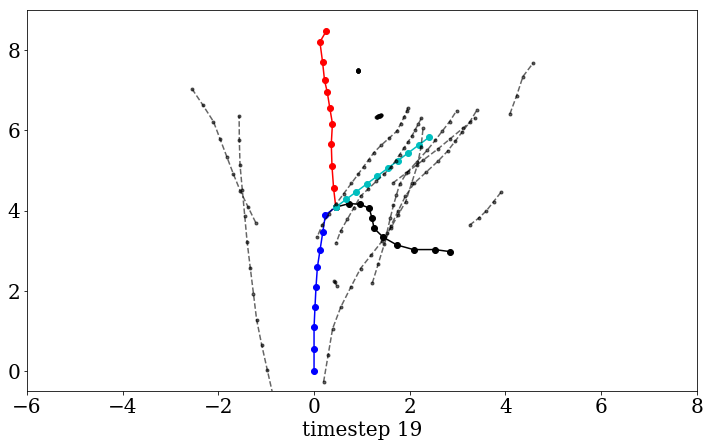

In [12]:
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc
makeDynamicPlot(1621)


In [101]:
output_speed[:,,:].shape

(11, 2)